## Index:
* [Introduction](#intro)
* [Data Processing](#data-p)
* [Descriptive Analysis of Dataset Values](#descriptive-a)
* [Feature Extraction - Applying Time Window](#applying-t)
* [Feature Extraction - Applying Feature Extraction Techniques](#applying-f)
* [Machine Learning - Experiments](#machine-l)

# Introduction <a class="anchor" id="intro"></a>
## Pre-Processing of the 2016-ANSAMO Dataset 

**Directory:**
    > `Subject_<nr>_ADL_<activity>.csv`
    > ...

**Types of Executed ADLs:**   
1) normal walking, 2) light jogging, 3) body bending, 4) hopping, 5) climbing stairs (up), 6) climbing stairs (down), 7) lying down and getting up from a bed, 8) sitting down (and up) on (from) a chair.

**Columns Units:**  
    After the header, every line in the files corresponds to a measurement captured by a particular mobility sensor of a determined node (mote or SensorTag).  
    The format of the lines, which is also explained in the file header, includes 7 numerical values separated by a semicolon:  
        -The time (in ms) since the experiment began.  
        -The number of the sample (for the same sensor and node).  
        -The three real numbers describing the measurements of the triaxial sensor (x-axis, y-axis and z-axis). The units are g, °/s or μT depending on whether the measurement was performed by an accelerometer, a gyroscope or a magnetometer, respectively.  
        -An integer (0, 1 or 2) describing the type of the sensor that originated the measurement (Accelerometer = 0 , Gyroscope = 1, Magnetometer = 2)  
        -An integer (from 0 to 4) informing about the sensing node (the correspondence between this numerical code and the Bluetooth MAC address and position of the motes is described in the file header).
        
## Desired Dataset Format

current header = TS(ms);SampleNr;X-Axis;Y-Axis;Z-Axis;SensorType;SensorID  
desired header = TS(ms); AccX; AccY; AccZ; MagnX; MagnY; MagnZ; GyroX; GyroY; GyroZ; SubjectID; Gender; Age; Position; Label; and other Feature Extraction Columns (mean, std, corr, etc...)

Pre-Processing Tasks:
    - clean headers information
    - divide the files by subject: "subject_01.csv"; "subject_02.csv"; ... with the desired header above.

In [ ]:
## Readme File ##
from IPython.display import IFrame
IFrame("./2016-ANSAMO-Readme.pdf", width=800, height=800)

In [31]:
def download_dataset(path):
    print("downloading dataset...")
    import sys
    sys.path.append('../../../')
    from ipynb.fs.full.Utils import download_from_google_drive
    download_from_google_drive('1fuMxj-dnMXEPHGhHwuQoNjBovO_v5Kdk', path);
    # https://drive.google.com/open?id=1fuMxj-dnMXEPHGhHwuQoNjBovO_v5Kdk
    print("saved at ", path)

In [17]:
def read_file(filepath):
    SUBJECTS = pd.DataFrame([
    {'id': 'Subject 01', 'age':'22', 'gender':'female', 'height':'167', 'weight': '63'},
    {'id': 'Subject 02', 'age':'27', 'gender':'male', 'height':'173', 'weight': '90'},
    {'id': 'Subject 03', 'age':'23', 'gender':'male', 'height':'179', 'weight': '68'}, 
    {'id': 'Subject 04', 'age':'24', 'gender':'male', 'height':'175', 'weight': '79'},
    {'id': 'Subject 05', 'age':'28', 'gender':'male', 'height':'195', 'weight': '81'},
    
    {'id': 'Subject 06', 'age':'22', 'gender':'female', 'height':'167', 'weight': '57'},
    {'id': 'Subject 07', 'age':'55', 'gender':'male', 'height':'170', 'weight': '83'},
    {'id': 'Subject 08', 'age':'19', 'gender':'male', 'height':'178', 'weight': '68'},
    {'id': 'Subject 09', 'age':'26', 'gender':'male', 'height':'176', 'weight': '73'},
    {'id': 'Subject 10', 'age':'51', 'gender':'female', 'height':'155', 'weight': '55'},
    
    {'id': 'Subject 11', 'age':'14', 'gender':'female', 'height':'159', 'weight': '50'},
    {'id': 'Subject 12', 'age':'22', 'gender':'female', 'height':'164', 'weight': '52'},
    {'id': 'Subject 13', 'age':'26', 'gender':'male', 'height':'179', 'weight': '67'},
    {'id': 'Subject 14', 'age':'21', 'gender':'male', 'height':'173', 'weight': '77'},
    {'id': 'Subject 15', 'age':'27', 'gender':'female', 'height':'166', 'weight': '66'},
    
    {'id': 'Subject 16', 'age':'24', 'gender':'male', 'height':'177', 'weight': '66'},
    {'id': 'Subject 17', 'age':'23', 'gender':'female', 'height':'163', 'weight': '93'},
])
    filename = ""
    try:
        filepath.index("/");
        array = filepath.split('/');
        filename = array[len(array) - 1]
    except:
        filename = filepath
    print(filename)
    ## filename = UMAFall_Subject_01_ADL_Bending_1_2016-06-13_20-25-34.csv
    array = filename.split('_')
    subjectID = array[1] + " " + array[2]
    label = array[4]
    experiment = array[4] + "_" + array[5]
    ### read csv
    train_dataRaw = pd.read_csv(filepath)
    ### remove first 31 lines
    train_data = train_dataRaw.iloc[31:]
    ### user characteristics
    user = SUBJECTS[SUBJECTS['id'].isin([subjectID])];
    age = user['age']
    gender = user['gender']
    height = user['height']
    weight = user['weight']

    return {"filecontent": train_data, 
             'experiment': experiment, 
             'label': label, 
             'subjectID': subjectID,
             'filename': filename, 
             'gender': gender.values[0], 
             'age': age.values[0], 
             'height': height.values[0], 
             'weight': weight.values[0]};
   

###output = read_file("../../../datasets/ANSAMO-2016/UMA_ADL_FALL_Dataset/UMAFall_Subject_01_ADL_Bending_1_2016-06-13_20-25-34.csv");

In [18]:
def split_positions_and_signals(filecontent):
    ''' filecontent = pd.DataFrame '''

    ##  Sensor_ID	 Position	 Device Model                                   
    #0	 RIGHTPOCKET	 lge-LG-H815-5.1                                
    #1	 CHEST	 SensorTag
    #2	 WAIST	 SensorTag
    #3	 WRIST	 SensorTag                                            
    #4	 ANKLE	 SensorTag                                                                                                            
    RIGHTPOCKET = '0'
    CHEST = '1'
    WAIST = '2'
    WRIST = '3'
    ANKLE = '4'
    #% Sensor_Type:                                                                     
    #% Accelerometer = 0                                                                
    #% Gyroscope = 1                                                                    
    #% Magnetometer = 2 
    ACCE = '0'
    GYRO = '1'
    MAGN = '2'
    
    ### divide line into several columns
    header_tmp = {'ts(ms)': [], 'SampleNr': [], 'X-Axis': [], 'Y-Axis': [], 'Z-Axis': [], 'SensorType': [] , 'SensorID': []}
    values = pd.DataFrame(data=header_tmp)
    i = 0
    for index, row in filecontent.iterrows():
            line = row[0]
            array = line.split(';')
            if i > 0: values = values.append(pd.DataFrame({'ts(ms)': [array[0]], 'SampleNr': [array[1]], 'X-Axis': [array[2]], 'Y-Axis': [array[3]], 'Z-Axis': [array[4]], 'SensorType': [array[5]] , 'SensorID': [array[6]]}))
            i+=1;
    ### sorting per sensorid, sensortype, and ts
    train_data_processed_ordered = values.sort_values(['SensorID', 'SensorType', 'ts(ms)']);
    ### start splitting into positions and signals
    # divide signals per position
    train_data_pocket = train_data_processed_ordered[train_data_processed_ordered['SensorID'].isin([RIGHTPOCKET])];
    train_data_chest = train_data_processed_ordered[train_data_processed_ordered['SensorID'].isin([CHEST])];
    train_data_waist = train_data_processed_ordered[train_data_processed_ordered['SensorID'].isin([WAIST])];
    train_data_wrist = train_data_processed_ordered[train_data_processed_ordered['SensorID'].isin([WRIST])];
    train_data_ankle = train_data_processed_ordered[train_data_processed_ordered['SensorID'].isin([ANKLE])];
    # pocket 
    pocket_acc = train_data_pocket[train_data_pocket['SensorType'].isin([ACCE])];
    pocket_gyro = train_data_pocket[train_data_pocket['SensorType'].isin([GYRO])];
    pocket_magn = train_data_pocket[train_data_pocket['SensorType'].isin([MAGN])];
    # wrist
    wrist_acc = train_data_wrist[train_data_wrist['SensorType'].isin([ACCE])];
    wrist_gyro = train_data_wrist[train_data_wrist['SensorType'].isin([GYRO])];
    wrist_magn = train_data_wrist[train_data_wrist['SensorType'].isin([MAGN])];
    # ankle
    ankle_acc = train_data_ankle[train_data_ankle['SensorType'].isin([ACCE])];
    ankle_gyro = train_data_ankle[train_data_ankle['SensorType'].isin([GYRO])];
    ankle_magn = train_data_ankle[train_data_ankle['SensorType'].isin([MAGN])];
    # waist
    waist_acc = train_data_waist[train_data_waist['SensorType'].isin([ACCE])];
    waist_gyro = train_data_waist[train_data_waist['SensorType'].isin([GYRO])];
    waist_magn = train_data_waist[train_data_waist['SensorType'].isin([MAGN])];
    # chest
    chest_acc = train_data_chest[train_data_chest['SensorType'].isin([ACCE])];
    chest_gyro = train_data_chest[train_data_chest['SensorType'].isin([GYRO])];
    chest_magn = train_data_chest[train_data_chest['SensorType'].isin([MAGN])];
    
    return {'pocket_acc':pocket_acc,
           'pocket_gyro':pocket_gyro,
           'pocket_magn':pocket_magn,
           
           'wrist_acc':wrist_acc,
           'wrist_gyro':wrist_gyro,
           'wrist_magn':wrist_magn,
           
           'ankle_acc':ankle_acc,
           'ankle_gyro':ankle_gyro,
           'ankle_magn':ankle_magn,
           
           'waist_acc':waist_acc,
           'waist_gyro':waist_gyro,
           'waist_magn':waist_magn,
           
           'chest_acc':chest_acc,
           'chest_gyro':chest_gyro,
           'chest_magn':chest_magn,
           
            'train_data_pocket':train_data_pocket,
            'train_data_chest':train_data_chest,
            'train_data_waist':train_data_waist,
            'train_data_wrist':train_data_wrist,
            'train_data_ankle':train_data_ankle,
           };

##filecontent = pd.DataFrame(output['filecontent']);
##values = split_positions_and_signals(filecontent);

In [19]:
def join_all_signals_types(signals, info):
    ''' Receives the argument: 
    sigmals = pd.DataFrame([
    {   'value': pocket_acc, 'signalType': 'acc'},  {'value': pocket_gyro, 'signalType': 'gyro'}, ... 
    info = pd.DataFrame([{
        'userGender': 'male',
        'userAge': '55',
        'userID':'sdasd'
        'position': 2
        'filename': 'asda.csv',
        'experiment': 'Bending_1',
        'label': 'Bending'}]) 
    '''
    userAge = info['userAge']
    userGender = info['userGender']
    userID = info['userID']
    label = info['label']
    filename = info['filename']
    experiment = info['experiment']
    
    header = [ 'ts(ms)', 'accX', 'accY', 'accZ',
              'magX', 'magY', 'magZ',
              'gyrX', 'gyrY', 'gyrZ',
              'userGender', 'userAge', 'userID',
              'position', 
              'label',
              'filename',
              'experiment' ];
    all_values = pd.DataFrame(columns=header);
    
    for indexR, lineR in signals.iterrows():
        array = lineR['value'];
        signalType = lineR['signalType'];
        position = lineR['position'];
        
        for index, line in array.iterrows():
            row = all_values[all_values['ts(ms)'] == line['ts(ms)']];
            ts_tmp = [line['ts(ms)']];
            
            if signalType is "acc": 
                 acc_values_tmp = [ [line['X-Axis']] ,  [line['Y-Axis']],  [line['Z-Axis']]];
                 magn_values_tmp = [ [-1] ,  [-1],  [-1]];
                 gyro_values_tmp = [ [-1] ,  [-1],  [-1]]; 
            elif signalType is "magn":
                 acc_values_tmp = [ [-1] ,  [-1],  [-1]]; 
                 magn_values_tmp = [ [line['X-Axis']] ,  [line['Y-Axis']],  [line['Z-Axis']]];
                 gyro_values_tmp = [ [-1] ,  [-1],  [-1]]; 
            else:
                acc_values_tmp = [ [-1] ,  [-1],  [-1]];    
                magn_values_tmp = [ [-1] ,  [-1],  [-1]];
                gyro_values_tmp = [ [line['X-Axis']] ,  [line['Y-Axis']],  [line['Z-Axis']]];      

            if row.size == 0:
                all_values = all_values.append(pd.DataFrame({'ts(ms)': ts_tmp, 
                                    'accX':acc_values_tmp[0],
                                    'accY':acc_values_tmp[1],
                                    'accZ': acc_values_tmp[2], 
                                    'magX':magn_values_tmp[0],
                                    'magY':magn_values_tmp[1], 
                                    'magZ': magn_values_tmp[2], 
                                    'gyrX':gyro_values_tmp[0],
                                    'gyrY': gyro_values_tmp[1],
                                    'gyrZ': gyro_values_tmp[2], 
                                    'userGender': userGender, 
                                    'userAge': userAge, 
                                    'userID': userID,
                                    'position': position, 
                                    'label':label.values,
                                    'filename':filename,
                                    'experiment': experiment}))
            else:
                row.at[index, 'accX'] = acc_values_tmp[0];
                row.at[index, 'accY'] = acc_values_tmp[1];
                row.at[index, 'accZ'] = acc_values_tmp[2];
                
                row.at[index, 'gyrX'] = gyro_values_tmp[0];
                row.at[index, 'gyrY'] = gyro_values_tmp[1];
                row.at[index, 'gyrZ'] = gyro_values_tmp[2];
                
                row.at[index, 'magZ'] = magn_values_tmp[2];
                row.at[index, 'magZ'] = magn_values_tmp[2];
                row.at[index, 'magZ'] = magn_values_tmp[2];
                
    return all_values;

###
###signals = pd.DataFrame([{'value': wrist_gyro, 'signalType': 'gyro'}])
###all_values = join_all_signals_types(signals)
###print("len of all values:", len(all_values));

In [20]:
def process_file(filePath):
    ### read file
    output = read_file(filePath)
    filecontent = pd.DataFrame(output['filecontent']);
    ###
    experiment = output['experiment'];
    label = output['label'];
    subjectID = output['subjectID'];
    filename = output['filename'];
    gender = output['gender'];
    age = output['age'];
    height = output['height'];
    weight = output['weight'];
    info = pd.DataFrame([{
        'userGender': gender,
        'userAge': age,
        'userID': subjectID,
        'filename': filename,
        'experiment': experiment,
        'label': label
    }])
    ### split into positions and signal type
    values = split_positions_and_signals(filecontent);
    ### 
    pocket_acc = values['pocket_acc']
    pocket_gyro = values['pocket_gyro']
    pocket_magn = values['pocket_magn']

    wrist_acc = values['wrist_acc']
    wrist_gyro = values['wrist_gyro']
    wrist_magn = values['wrist_magn']

    ankle_acc = values['ankle_acc']
    ankle_gyro = values['ankle_gyro']
    ankle_magn = values['ankle_magn']

    waist_acc = values['waist_acc']
    waist_gyro = values['waist_gyro']
    waist_magn = values['waist_magn']

    chest_acc = values['chest_acc']
    chest_gyro = values['chest_gyro']
    chest_magn = values['chest_magn']

    signalsPocket = pd.DataFrame(
        [
         {'value': pocket_acc, 'signalType': 'acc', 'position': 'pocket'},
         {'value': pocket_gyro, 'signalType': 'gyro', 'position': 'pocket'},
         {'value': pocket_magn, 'signalType': 'magn', 'position': 'pocket'},
        ]);

    signalsAnkle = pd.DataFrame(
        [
        {'value': ankle_acc, 'signalType': 'acc', 'position': 'ankle'},
        {'value': ankle_gyro, 'signalType': 'gyro', 'position': 'ankle'},
        {'value': ankle_magn, 'signalType': 'magn', 'position': 'ankle'},
        ]);

    signalsWrist = pd.DataFrame(
        [
         {'value': wrist_acc, 'signalType': 'acc', 'position': 'wrist'},
         {'value': wrist_gyro, 'signalType': 'gyro', 'position': 'wrist'},
         {'value': wrist_magn, 'signalType': 'magn', 'position': 'wrist'},
        ]);

    signalsWaist = pd.DataFrame(
        [
        {'value': waist_acc, 'signalType': 'acc', 'position': 'waist'},
        {'value': waist_gyro, 'signalType': 'gyro', 'position': 'waist'},
        {'value': waist_magn, 'signalType': 'magn', 'position': 'waist'},
        ]);

    signalsChest = pd.DataFrame(
        [
        {'value': chest_acc, 'signalType': 'acc', 'position': 'chest'},
        {'value': chest_gyro, 'signalType': 'gyro', 'position': 'chest'},
        {'value': chest_magn, 'signalType': 'magn', 'position': 'chest'},
        ]);
    ### join all values
    all_values = join_all_signals_types(signalsPocket, info);
    all_values = all_values.append(join_all_signals_types(signalsAnkle, info))
    all_values = all_values.append(join_all_signals_types(signalsWrist, info))
    all_values = all_values.append(join_all_signals_types(signalsWaist, info))
    all_values = all_values.append(join_all_signals_types(signalsChest, info))
    
    return all_values;

In [21]:
from ipynb.fs.full.Utils import download_from_google_drive
help(download_from_google_drive)

Help on function download_from_google_drive in module ipynb.fs.full.Utils:

download_from_google_drive(id, destPath)
    This function downloads Google Drive Shared Files By Passing Its Sharing Link And The Desired Destination Path



In [36]:
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys, subprocess
dependencies = ['ipynb', 'googledrivedownloader']
subprocess.call([sys.executable, '-m', 'pip', 'install'] + dependencies)

download_dataset("./Dataset/ansamo.zip");
print("Please Unzip File... Press Enter When Done.");
yourvar = input('Choose a number: ')
base_path = './Dataset/ansamo/UMA_ADL_FALL_Dataset/'
files = os.listdir(base_path)
total = pd.DataFrame();
for file in files:
    if '.csv' in file:
        print("processing file: " + base_path + "/" + file + " wait...")
        filePath = base_path+"/"+file;
        values = process_file(filePath);
        total = total.append(values)

total.to_csv("all_values.csv", sep=',')
print("done!")   

downloading dataset...
The File Already Exists. Please Change The Path Destination.
saved at  ./Dataset/ansamo.zip
Please Unzip File... Press Enter When Done.
Choose a number: 
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_01_ADL_Bending_1_2016-06-13_20-25-34.csv wait...
UMAFall_Subject_01_ADL_Bending_1_2016-06-13_20-25-34.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_01_ADL_Bending_2_2016-06-13_20-26-15.csv wait...
UMAFall_Subject_01_ADL_Bending_2_2016-06-13_20-26-15.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_01_ADL_Bending_3_2016-06-13_20-26-59.csv wait...
UMAFall_Subject_01_ADL_Bending_3_2016-06-13_20-26-59.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_01_ADL_forwardFall_1_2016-06-13_20-43-52.csv wait...
UMAFall_Subject_01_ADL_forwardFall_1_2016-06-13_20-43-52.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_01_ADL_Hopping_1_2016-06-13_20-

processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_02_ADL_Hopping_3_2016-06-13_13-02-19.csv wait...
UMAFall_Subject_02_ADL_Hopping_3_2016-06-13_13-02-19.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_02_ADL_Jogging_1_2016-06-13_13-07-16.csv wait...
UMAFall_Subject_02_ADL_Jogging_1_2016-06-13_13-07-16.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_02_ADL_Jogging_2_2016-06-13_13-07-58.csv wait...
UMAFall_Subject_02_ADL_Jogging_2_2016-06-13_13-07-58.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_02_ADL_Jogging_3_2016-06-13_13-08-41.csv wait...
UMAFall_Subject_02_ADL_Jogging_3_2016-06-13_13-08-41.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_02_ADL_LyingDown_OnABed_1_2016-06-13_13-10-22.csv wait...
UMAFall_Subject_02_ADL_LyingDown_OnABed_1_2016-06-13_13-10-22.csv
processing file: ./Dataset/ansamo/UMA_ADL_FALL_Dataset//UMAFall_Subject_02_ADL_LyingDown_OnA

KeyboardInterrupt: 

# Data Processing <a class="anchor" id="data-p"></a>
## Joining All Values Of Each Signal Into Same Lines

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
base_path = "./Dataset/ansamo/";

In [43]:
###
### Read CSV File
###
all_values = pd.read_csv(base_path + "all_values.csv");
all_values.dtypes

Unnamed: 0      int64
accX          float64
accY          float64
accZ          float64
experiment     object
filename       object
gyrX          float64
gyrY          float64
gyrZ          float64
label          object
magX          float64
magY          float64
magZ          float64
position       object
ts(ms)          int64
userAge         int64
userGender     object
userID         object
dtype: object

In [41]:
###
###
###
print("nr of instances:", len(all_values))
list_of_users = list(set(all_values['userID']))
print("nr of users: ", len(list_of_users))
ageDistribution = list(set(all_values['userAge']))
print("age distribution", ageDistribution)
labels = list(set(all_values['label']))
print("labels:", labels)
print("\nusers :", list(set(all_values['userID'])))

nr of instances: 2843028
nr of users:  17
age distribution [14, 19, 51, 55, 22, 23, 24, 21, 26, 27, 28]
labels: ['lateralFall', 'GoDownstairs', 'forwardFall', 'Hopping', 'Sitting', 'Walking', 'Jogging', 'GoUpstairs', 'backwardFall', 'Bending', 'LyingDown']

users : ['Subject 15', 'Subject 06', 'Subject 08', 'Subject 02', 'Subject 01', 'Subject 14', 'Subject 09', 'Subject 07', 'Subject 12', 'Subject 03', 'Subject 17', 'Subject 04', 'Subject 10', 'Subject 16', 'Subject 13', 'Subject 05', 'Subject 11']


In [44]:
###
### Each User With A Separate File
###
users = list(set(all_values['userID']));

for line in users:
    subject_index = all_values[all_values['userID'].isin([line])]
    print(line, " " , len(subject_index))
    subject_index.to_csv(base_path + "_" + line + ".csv");

Subject 15   128784
Subject 06   61969
Subject 08   85714
Subject 02   183943
Subject 01   236210
Subject 14   67276
Subject 09   221925
Subject 07   93653
Subject 12   167738
Subject 03   227716
Subject 17   150759
Subject 04   235954
Subject 10   90067
Subject 16   555730
Subject 13   117225
Subject 05   129682
Subject 11   88683


In [45]:
from math import fabs
def sliding_window(values, time_interval_ms, time_interval_unc):
    ''' ( values, time_interval_ms, time_interval_unc)
    '''
    old_ts = 0;
    old_acc = [-1,-1,-1];
    old_gyr = [-1,-1,-1];
    old_mag = [-1,-1,-1];
    header = [ 'Its(ms)', 'Fts(ms)',
                  'accX', 'accY', 'accZ',
                  'magX', 'magY', 'magZ',
                  'gyrX', 'gyrY', 'gyrZ',
                  'userGender', 'userAge', 'userID',
                  'position', 
                  'label',
                  'filename',
                  'experiment' ];
    final_values = pd.DataFrame(columns=header);
    values = values.sort_values(['ts(ms)']);

    for index, line in values.iterrows():
        ts = line['ts(ms)']
        acc = [ line['accX'], line['accY'],  line['accZ']]
        gyr = [ line['gyrX'], line['gyrY'],  line['gyrZ']]
        mag = [ line['magX'], line['magY'],  line['magZ']]
        if acc[0] != -1:
            old_acc = acc;
        if gyr[0] != -1:
            old_gyr = gyr;
        if mag[0] != -1:
            old_mag = mag;    
        diff = ts - old_ts;
        
        if diff < 0:
            raise ValueError('The List Is Not Sorted By Time!!!') 

        if diff == time_interval_ms or fabs(diff - time_interval_ms) <= time_interval_unc:
            final_values = final_values.append(pd.DataFrame([{
                 'Its(ms)': old_ts, 'Fts(ms)': ts,
                  'accX': old_acc[0], 'accY': old_acc[1], 'accZ': old_acc[2],
                  'magX': old_mag[0], 'magY': old_mag[1], 'magZ': old_mag[2],
                  'gyrX': old_gyr[0], 'gyrY': old_gyr[1], 'gyrZ': old_gyr[2],
                  'userGender': line['userGender'], 'userAge': line['userAge'], 'userID': line['userID'],
                  'position': line['position'], 
                  'label': line['label'],
                  'filename': line['filename'],
                  'experiment': line['experiment']}]));
            old_ts = ts;
        elif diff > time_interval_ms:
            old_ts = ts;
    return final_values;

In [46]:
time_interval_ms = 50;
time_interval_unc = 10;
final_array = pd.DataFrame()
# users
users = list(set(all_values['userID']));
for line in users:
    subject = all_values[all_values['userID'].isin([line])]
    print(line, ", ", len(subject))
    #experiments
    experiments = list(set(subject['experiment']))
    for lineExp in experiments:
        subject_exp = subject[subject['experiment'].isin([lineExp])]        
        #positions
        positions = list(set(subject_exp['position']))
        for linePos in positions:
            subject_exp_pos = subject_exp[subject_exp['position'].isin([linePos])]
            final_array = final_array.append(sliding_window(subject_exp_pos, time_interval_ms, time_interval_unc));      
    print(len(final_array));
    
final_array.to_csv("all_users_50ms.csv");

Subject 15 ,  128784
24517
Subject 06 ,  61969
37345
Subject 08 ,  85714
49534
Subject 02 ,  183943
86232
Subject 01 ,  236210
131923
Subject 14 ,  67276
145530
Subject 09 ,  221925
191602
Subject 07 ,  93653
204519
Subject 12 ,  167738
230380
Subject 03 ,  227716
275029
Subject 17 ,  150759
296652
Subject 04 ,  235954
340987
Subject 10 ,  90067
353839
Subject 16 ,  555730
442063
Subject 13 ,  117225
465782
Subject 05 ,  129682
490707
Subject 11 ,  88683
503779


## Data Processing
### Filtering Values - Removing pocket signals, falling labels

In [7]:
all_values = pd.read_csv("./Dataset/ansamo/t1-2_all_users_50ms.csv");

In [8]:
# Remove pocket signals
positions = list(set(all_values['position']))
print(positions)
print("all signals: ", len(all_values));
all_values = all_values[~all_values['position'].isin(['pocket'])];
print("non-pocket signals: ", len(all_values));

['waist', 'pocket', 'ankle', 'chest', 'wrist']
all signals:  503779
non-pocket signals:  361149


In [9]:
# Remove falling labels except Sitting, GoUpstairs, Bending, Walking, Jogging, Hoping, GoDownstairs
labels = list(set(all_values['label']))
print(labels)
desired_labels = ['Sitting', 'Bending', 'Walking', 'Jogging', 'Hopping', 
                  'GoUpstairs', 'GoDownstairs']
all_values_2 = all_values[all_values['label'].isin(desired_labels)];
print(len(all_values))
print(len(all_values_2))

['LyingDown', 'Hopping', 'Walking', 'lateralFall', 'forwardFall', 'Bending', 'Sitting', 'GoDownstairs', 'GoUpstairs', 'backwardFall', 'Jogging']
361149
175375


In [10]:
positions = list(set(all_values_2['position']))
print(positions)
labels = list(set(all_values_2['label']))
print(labels)
age = list(set(all_values_2['userAge']))
print(age)

old = all_values_2[all_values_2['userAge'].isin(['55'])];
labels = list(set(old['label']))
print(labels)

old = all_values_2[all_values_2['userAge'].isin(['51'])];
labels = list(set(old['label']))
print(labels)

['wrist', 'ankle', 'chest', 'waist']
['Hopping', 'Walking', 'Bending', 'Sitting', 'GoDownstairs', 'GoUpstairs', 'Jogging']
[14, 19, 23, 21, 22, 55, 24, 51, 26, 27, 28]
['Hopping', 'Walking', 'Bending', 'Sitting', 'GoDownstairs', 'GoUpstairs']
['Hopping', 'Walking', 'Bending', 'Sitting', 'GoDownstairs', 'GoUpstairs']


,Unnamed: 0,Fts(ms),Its(ms),accX,accY,accZ,experiment,filename,gyrX,gyrY,gyrZ,label,magX,magY,magZ,position,userAge,userGender,userID


In [12]:
all_values_2.to_csv("./Dataset/ansamo/t1-3_all_values_50ms.csv");

## Descriptive Analysis <a class="anchor" id="descriptive-a"></a>
#### Descriptive Analysis of Signals In Each Experiment

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
all_values = pd.read_csv("./Dataset/ansamo/t1-3_all_values_50ms.csv");

In [2]:
all_values.describe()

,Unnamed: 0,Unnamed: 0.1,Fts(ms),Its(ms),accX,accY,accZ,gyrX,gyrY,gyrZ,magX,magY,magZ,userAge
count,175375.000000,175375.0,175375.000000,175375.00000,175375.000000,175375.000000,175375.000000,175375.000000,175375.000000,175375.000000,175375.000000,175375.000000,175375.000000,175375.000000
mean,252762.787883,0.0,7505.649488,7457.47147,0.600532,-0.055701,0.075002,-2.126005,-0.171710,-0.794811,-11.509510,-7.031505,-28.754855,26.158227
std,147975.319402,0.0,4208.938001,4209.05653,0.935383,0.462584,0.525032,65.190146,69.084292,51.765024,65.091665,58.132460,101.711870,8.727373
min,1368.000000,0.0,50.000000,0.00000,-6.892090,-8.000000,-7.937256,-256.898438,-257.000000,-256.828125,-187.500000,-192.000000,-234.666672,14.000000
25%,128985.500000,0.0,3850.000000,3801.00000,0.125977,-0.184570,-0.107178,-14.554688,-13.500000,-8.398438,-59.500000,-19.333334,-107.333336,22.000000
50%,243539.000000,0.0,7472.000000,7424.00000,0.918945,-0.050049,0.089600,-1.718750,-0.281250,-1.148438,-12.500000,-1.500000,-26.166666,24.000000
75%,380984.500000,0.0,11065.000000,11017.00000,1.007324,0.068359,0.297363,10.558594,10.500000,7.101562,38.166668,33.333332,50.833332,27.000000
max,503778.000000,0.0,15036.000000,14982.00000,8.000000,7.937256,8.000000,254.992188,254.812500,254.898438,146.833328,98.333336,218.500000,55.000000


In [3]:
def create_figure(time , sensorX_y, sensorY_y, sensorZ_y, 
                 fig_title,
                 label_x,
                 label_y,
                destPath):
    
    import pylab as plt
    import numpy as np
    fig, axs=plt.subplots(1,3)
    fig.set_size_inches(30, 5, forward=True)
    fig.set_dpi(200)
    ax=axs.ravel()
    
    ax[0].plot(time, sensorX_y)
    ax[1].plot(time, sensorY_y)
    ax[2].plot(time, sensorZ_y)
    
    ax[0].set_title("X-AXIS")
    ax[0].set_ylabel(label_y)
    ax[0].set_xlabel(label_x)

    ax[1].set_title("Y-AXIS")
    ax[1].set_ylabel(label_y)
    ax[1].set_xlabel(label_x)
    
    ax[2].set_title("Z-AXIS")
    ax[2].set_ylabel(label_y)
    ax[2].set_xlabel(label_x)

    fig.suptitle(fig_title, fontsize=20)
    fig.savefig(destPath)
    plt.close(fig);
    plt.close()

In [4]:
# Descriptive Analysis of Each Signal During Each Experiment
users = list(set(all_values['userID']));
users.sort()
# users
for line in users:
    subject = all_values[all_values['userID'].isin([line])]
    print(line, ", ", len(subject))
    #experiments
    experiments = list(set(subject['experiment']))
    for lineExp in experiments:
        subject_exp = subject[subject['experiment'].isin([lineExp])]        
        #positions
        positions = list(set(subject_exp['position']))
        for linePos in positions:
            subject_exp_pos = subject_exp[subject_exp['position'].isin([linePos])]
            subject01_exp_pos_sor = subject_exp_pos.sort_values(['Fts(ms)'])
            time = subject01_exp_pos_sor['Fts(ms)'].values
            # acc
            sensorX_y = subject01_exp_pos_sor['accX'].values;
            sensorY_y = subject01_exp_pos_sor['accY'].values;
            sensorZ_y = subject01_exp_pos_sor['accZ'].values;
            fig_title = "ACC_" + line + "_" + lineExp + "_" + linePos
            label_y = "G"
            label_x = "TS(MS)"
            destPath = "./Dataset/Signals Analysis/" + fig_title + ".jpg"
            create_figure(time,
                          sensorX_y, sensorY_y, sensorZ_y, 
                          fig_title, label_x, label_y, destPath);
            # mag
            sensorX_y = subject01_exp_pos_sor['magX'].values;
            sensorY_y = subject01_exp_pos_sor['magY'].values;
            sensorZ_y = subject01_exp_pos_sor['magZ'].values;
            fig_title = "MAG_" + line + "_" + lineExp + "_" + linePos
            label_y = "uT"
            label_x = "TS(MS)"
            destPath = "./Dataset/Signals Analysis/" + fig_title + ".jpg"
            create_figure(time,
                          sensorX_y, sensorY_y, sensorZ_y, 
                          fig_title, label_x, label_y, destPath);
            # gyr
            sensorX_y = subject01_exp_pos_sor['gyrX'].values;
            sensorY_y = subject01_exp_pos_sor['gyrY'].values;
            sensorZ_y = subject01_exp_pos_sor['gyrZ'].values;
            fig_title = "GYR_" + line + "_" + lineExp + "_" + linePos
            label_y = "degrees/second"
            label_x = "TS(MS)"
            destPath = "./Dataset/Signals Analysis/" + fig_title + ".jpg"
            create_figure(time,
                          sensorX_y, sensorY_y, sensorZ_y, 
                          fig_title, label_x, label_y, destPath);

['Subject 01', 'Subject 02', 'Subject 03', 'Subject 04', 'Subject 05', 'Subject 06', 'Subject 07', 'Subject 08', 'Subject 09', 'Subject 10', 'Subject 11', 'Subject 12', 'Subject 13', 'Subject 14', 'Subject 15', 'Subject 16', 'Subject 17']
Subject 10 ,  7486
Subject 11 ,  7786
Subject 12 ,  11845
Subject 13 ,  5464
Subject 14 ,  4202
Subject 15 ,  7436
Subject 16 ,  25950
Subject 17 ,  5489


MemoryError: 

In [4]:
# Descriptive Analysis of Each Signal Per Label
def create_figure(x, y, title, destPath):
    import matplotlib.pyplot as plt
    import pandas as pd
    %matplotlib inline
    fig = plt.figure();
    fig.set_size_inches(15, 5)
    fig.set_dpi(200)
    fig.suptitle(title, fontsize=20)
    plt.scatter(x,y)
    fig.savefig(destPath)
    plt.close(fig);
    plt.close()
    
users = list(set(all_values['userID']));
users.sort()
# users
for line in users:
    subject = all_values[all_values['userID'].isin([line])]
    print(line, ", ", len(subject))
    #positions
    positions = list(set(subject['position']))
    for linePos in positions:
        subject_pos = subject[subject['position'].isin([linePos])]
        subject_pos = subject_pos.sort_values(['label', 'Fts(ms)'])
        label = subject_pos['label'].values
        
        #
        accX = subject_pos['accX'].values
        accY = subject_pos['accY'].values
        accZ = subject_pos['accZ'].values
        create_figure(accX,label, "ACC-X", "./Dataset/" + line + "_" + linePos + "_ACC-X.jpg")
        create_figure(accY,label, "ACC-Y", "./Dataset/" + line + "_" + linePos +"_ACC-Y.jpg")
        create_figure(accZ,label, "ACC-Z", "./Dataset/" + line + "_" + linePos + "_ACC-Z.jpg")
        #
        magX = subject_pos['magX'].values
        magY = subject_pos['magY'].values
        magZ = subject_pos['magZ'].values
        create_figure(magX,label, "MAG-X", "./Dataset/" + line + "_"+ linePos + "_MAG-X.jpg")
        create_figure(magY,label, "MAG-Y", "./Dataset/" + line + "_"+ linePos + "_MAG-Y.jpg")
        create_figure(magZ,label, "MAG-Z", "./Dataset/" + line + "_"+ linePos + "_MAG-Z.jpg")
        #
        gyrX = subject_pos['gyrX'].values
        gyrY = subject_pos['gyrY'].values
        gyrZ = subject_pos['gyrZ'].values
        create_figure(gyrX,label, "GYR-X", "./Dataset/" + line + "_"+ linePos + "_GYR-X.jpg")
        create_figure(gyrY,label, "GYR-Y", "./Dataset/" + line + "_"+ linePos + "_GYR-Y.jpg")
        create_figure(gyrZ,label, "GYR-Z", "./Dataset/" + line + "_"+ linePos +"_GYR-Z.jpg")

Subject 01 ,  13998
Subject 02 ,  14318
Subject 03 ,  13682
Subject 04 ,  14420
Subject 05 ,  11080
Subject 06 ,  3241
Subject 07 ,  7425
Subject 08 ,  7087
Subject 09 ,  14466
Subject 10 ,  7486
Subject 11 ,  7786
Subject 12 ,  11845
Subject 13 ,  5464
Subject 14 ,  4202
Subject 15 ,  7436
Subject 16 ,  25950
Subject 17 ,  5489


In [3]:
# Labels Per Users
users = list(set(all_values['userID']));
users.sort()
# users
for line in users:
    subject = all_values[all_values['userID'].isin([line])]
    labels = list(set(subject['label']))
    print(line , " " , labels)

Subject 01   ['Walking', 'Hopping', 'Sitting', 'Bending', 'Jogging']
Subject 02   ['Walking', 'Hopping', 'Sitting', 'Bending', 'Jogging']
Subject 03   ['Walking', 'Hopping', 'Sitting', 'Bending', 'Jogging']
Subject 04   ['Walking', 'Hopping', 'Sitting', 'Bending', 'Jogging']
Subject 05   ['Walking', 'Hopping', 'Bending', 'Sitting']
Subject 06   ['Bending', 'Walking', 'Sitting']
Subject 07   ['Walking', 'Hopping', 'Sitting', 'Bending', 'GoDownstairs', 'GoUpstairs']
Subject 08   ['Walking', 'Hopping', 'Sitting', 'Bending', 'GoDownstairs', 'GoUpstairs']
Subject 09   ['Walking', 'Hopping', 'Sitting', 'Bending', 'Jogging']
Subject 10   ['Walking', 'Hopping', 'Sitting', 'Bending', 'GoDownstairs', 'GoUpstairs']
Subject 11   ['Walking', 'Hopping', 'Sitting', 'Bending', 'GoDownstairs', 'GoUpstairs']
Subject 12   ['Walking', 'Hopping', 'Sitting', 'Bending', 'GoDownstairs', 'GoUpstairs']
Subject 13   ['Walking', 'Hopping', 'Sitting', 'Bending', 'Jogging']
Subject 14   ['Bending', 'Walking', 'Sitt

## Feature Extraction <a class="anchor" id="feature-e"></a>

### Applying Time Window <a class="anchor" id="applying-t"></a>

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import fabs
          
def apply_window_v2(array):
    old_ts = array.iloc[0]['Fts(ms)'];
    i = 0;
    values = []
    values_accX = []
    values_accY = []
    values_accZ = []

    values_gyrX = []
    values_gyrY = []
    values_gyrZ = []

    values_magX = []
    values_magY = []
    values_magZ = []
    out = pd.DataFrame()

    for index, line in array.iterrows():
        ts = line['Fts(ms)']       
        accX = line['accX']
        accY = line['accY']
        accZ = line['accZ']

        magX = line['magX']
        magY = line['magY']
        magZ = line['magZ']

        gyrX = line['gyrX']
        gyrY = line['gyrY']
        gyrZ = line['gyrZ']

        diff = ts - old_ts;
        # add values  values += [ts]
        values += [ts]
        values_accX += [accX]
        values_accY += [accY]
        values_accZ += [accZ]

        values_gyrX += [gyrX]
        values_gyrY += [gyrY]
        values_gyrZ += [gyrZ]

        values_magX += [magX]
        values_magY += [magY]
        values_magZ += [magZ]
        #
        if diff == WINDOW or fabs(diff - WINDOW) <= UNCERTAINTY:
            i+=1
            old_ts = ts
            out = out.append(pd.DataFrame([{
         'Its(ms)': line['Its(ms)'], 'Fts(ms)': line['Fts(ms)'],
          'accX': values_accX, 'accY': values_accY, 'accZ': values_accZ,
          'magX': values_magX, 'magY': values_magY, 'magZ': values_magZ,
          'gyrX': values_gyrX, 'gyrY': values_gyrY, 'gyrZ': values_gyrZ,
          'userGender': line['userGender'], 'userAge': line['userAge'], 'userID': line['userID'],
          'position': line['position'], 
          'label': line['label'],
          'filename': line['filename'],
          'experiment': line['experiment']}]));

            ### set values  values = [old_ts]
            values = [old_ts]
            values_accX = [accX]
            values_accY = [accY]
            values_accZ = [accZ]
            values_gyrX = [gyrX]
            values_gyrY = [gyrY]
            values_gyrZ = [gyrZ]
            values_magX = [magX]
            values_magY = [magY]
            values_magZ = [magZ]
            continue
        elif diff > WINDOW or old_ts == -1:
            old_ts = ts
            # set values values = [old_ts]
            values = [old_ts]
            values_accX = [accX]
            values_accY = [accY]
            values_accZ = [accZ]
            values_gyrX = [gyrX]
            values_gyrY = [gyrY]
            values_gyrZ = [gyrZ]
            values_magX = [magX]
            values_magY = [magY]
            values_magZ = [magZ]
            
    return out;      

all_values = pd.read_csv("./t1-3_all_values_50ms.csv");
#subject = all_values[all_values['userID'].isin(['Subject 01'])]
#subject_pos = subject[subject['position'].isin(['ankle'])]
#subject_pos_label = subject_pos[subject_pos['experiment'].isin(['Walking_3'])]
#subject_pos_label = subject_pos_label.sort_values(['Fts(ms)'])
print("len(all_values):", len(all_values))
print("len(all_values.columns):", len(all_values.columns))
WINDOW = 2000;
UNCERTAINTY = 500;
users = list(set(all_values['userID']));
all_values_with_window = pd.DataFrame();
for line in users:
        print(line)
        subject = all_values[all_values['userID'].isin([line])]
        print("len(subject):", len(subject))
        #experiments
        experiments = list(set(subject['experiment']))
        for lineExp in experiments:     
            subject_exp = subject[subject['experiment'].isin([lineExp])]    
            #positions
            positions = list(set(subject_exp['position']))
            for linePos in positions:
                subject_exp_pos = subject_exp[subject_exp['position'].isin([linePos])]
                subject_pos_label = subject_exp_pos.sort_values(['Fts(ms)'])
                # applying sliding window
                out = apply_window_v2(subject_pos_label);
                all_values_with_window = all_values_with_window.append(out);

#all_values_with_window.to_csv("t1-42_all_values_with_window_" + str(WINDOW) + "_ms.csv");
print("len(all_values_with_window):", len(all_values_with_window))
print("len(all_values_with_window.columns):", len(all_values_with_window.columns))
#print(out.head(5)['magY'])
#print()
#print(subject_pos_label.head(5)['magY'])

### Applying FE Techniques <a class="anchor" id="applying-f"></a>

In [140]:
### statistical fe
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy import ndimage
from scipy.stats import iqr
import numpy as np
from astropy.stats import median_absolute_deviation
from numpy.random import randn
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import pearsonr

def ske(args):
    # skeweness
    if len(args) != 1:
        raise BaseException("Can Only Handle With One Array")
    return skew(args[0]);
def kur(args):
    # kurtosis
    if len(args) != 1:
        raise BaseException("Can Only Handle With One Array")
    return kurtosis(args[0])
#*
def his(args):
    # histogram
    if len(args) != 1:
        raise BaseException("Can Only Handle With One Array")
    return np.histogram(args[0])
# 

### time-series fe
def avg(args):
    # mean
    out = []
    for arg in args:
        out += arg
    return np.mean(out);
def maxi(args):
    #max
    out = []
    for arg in args:
        out += arg
    return np.array(out).max();
def mini(args):
    #minimum
    out = []
    for arg in args:
        out += arg
    return np.array(out).min();
def var(args):
    #variance https://docs.scipy.org/doc/numpy-1.6.0/reference/generated/numpy.var.html
    out = []
    for arg in args:
        out += arg
    return np.var(out);
#*
def cen(args):
    #centroid
    if len(args) == 1:
        return float(ndimage.measurements.center_of_mass(pd.Series(args[0]))[0]);
    else:
        raise BaseException("Invalid Arguments"); 
        
def std(args):
    # standard deviation https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.std.html
    out = []
    for arg in args:
        out += arg
    return np.std(out);
def rms(args):
    # root mean square
    out = []
    for arg in args:
        out += arg
    return np.sqrt(np.mean(pd.Series(out)**2))
# * 
def iqrr(args):
    #interquartile range
    out = []
    for arg in args:
        out += arg
    return iqr(pd.Series(args[0]))
def mad(args):
    #mean absolute deviation
    out = []
    for arg in args:
        out += arg
    return median_absolute_deviation(out)
#*
def zcr(args):
    raise BaiseException("Not Yet Implemented")
    #zero crossing rate
    out = args[0]
    for arg in args:
        out += arg
    return ((out[:-1] * out[1:]) < 0).sum()
#*
def cec(args):
    raise BaiseException("Not Yet Implemented")
    #cepstral coefficients https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html
    out = args[0]
    for arg in args:
        out += arg
    y, sr = librosa.load(librosa.util.example_audio_file())
    return librosa.feature.mfcc(y=y, sr=sr)
def cor(args):
    #pearson correlation
    #if len(args) == 2:
    #    return args[0].corr(args[1], method='pearson')
    #else:
    #    raise BaseException("Invalid Arguments");        
    # x-y
    if len(args) == 2:
        return float(pearsonr(args[0], args[1])[0]);
    else:
        raise BaseException("Invalid Arguments");        

def aco(args):
    #autocorrelation
    if len(args) == 1:
        if not isinstance(args[0], pd.Series):
            args[0] = pd.Series(args[0])
        #print(type(args[0]))
        return args[0].autocorr()
    else:
        raise BaseException("Invalid Arguments");    

data = pd.Series([1,2,3,4,5,6]);

print(ske([[1,2]]))
print(kur([[1,2]]))
print(avg([[1,2]]))
print(maxi([[1,2]]))
print(mini([[1,2]]))
print(var([[1,2]]))
print(cen([[1,2,3,4,5,6,7,8,9]]))
print(std([[1,2]]))
print(rms([[1,2]]))
print(iqrr([[1,2,3,4,5,6,7]]))
print(mad([[1,2,3,4,5,9]]))
#print(zcr([data]))
#print(cec([data]))
print("cor:", cor([data, data]))
print(aco([pd.Series([0.968994140625, 0.9775390625, 0.971435546875])]))

0.0
-2.0
1.5
2
1
0.25
5.333333333333333
0.5
1.58113883008
3.0
1.5
cor: 1.0
-1.0


In [141]:
def extract_features(data, fefunctions):
    out = data.copy();
    # data = [ [1,2] , [2,3]]
    # columns = ['accX', 'accY', ['accX', 'accY']]
    # fefunction = [avg, ['accX', 'accY', 'accZ']]
    for i in fefunctions:
        columns = i[1]
        fefunction = i[0]
        for selected_columns in columns:
            #name = "avg_";
            name = str(fefunction.__name__)
            if isinstance(selected_columns, list):
                array = pd.DataFrame();
                for selected_column in selected_columns:
                    name += "_" + str(selected_column);
                    array = array.assign(**{selected_column: data[selected_column].values})
            else:
                try:
                    array = pd.DataFrame(data[selected_columns])
                    name += "_" + str(selected_columns);
                except:
                    print("Invalid Column", str(selected_columns) , " !!!");
                    continue;
            #
            new_column = pd.DataFrame(columns=[name]);
            # calculate         
            for index, line in array.iterrows():
                window_values = []
                nr_columns = len(array.columns)
                for column in range(0, nr_columns):
                    window_values += [line[column]]
                # mean
                print("type(window_values):", type(window_values))
                mean = fefunction(window_values)
                #print(mean)
                new_column = new_column.append(pd.DataFrame({name: [mean]}), ignore_index=True);
            #
            #print("len(new_column):", len(new_column))
            out = out.assign(**{name: new_column[name].values})
    return out;

### 
all_values = all_values_with_window;
all_values_with_fe = pd.DataFrame()
users = list(set(all_values['userID']));
#users.sort()
# users
for line in users:
    subject = all_values[all_values['userID'].isin([line])]
    #experiments
    experiments = list(set(subject['experiment']))
    print(line)
    for lineExp in experiments:     
        subject_exp = subject[subject['experiment'].isin([lineExp])]    
        #positions
        positions = list(set(subject_exp['position']))
        for linePos in positions:
            subject_exp_pos = subject_exp[subject_exp['position'].isin([linePos])]
            subject_pos_label = subject_exp_pos.sort_values(['Fts(ms)'])
            # applying feature extraction
            print("subject_pos_label:", type(subject_pos_label))
            all_values_with_fe = all_values_with_fe.append(extract_features(subject_pos_label, [ 
                                # statistical 
                                [ske, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ', 
                                       'magX', 'magY', 'magZ']],
    
                                [kur, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ', 
                                       'magX', 'magY', 'magZ']],
                                # time series
                                [avg, ['accX', 'accY', 'accZ', ['accX', 'accY', 'accZ'],
                                       'gyrX', 'gyrY', 'gyrZ', ['gyrX', 'gyrY', 'gyrZ'],
                                       'magX', 'magY', 'magZ', ['magX', 'magY', 'magZ']]],
    
                                [maxi, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ',
                                       'magX', 'magY', 'magZ']],
    
                                [mini, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ',
                                       'magX', 'magY', 'magZ']],
    
                                [var, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ',
                                       'magX', 'magY', 'magZ']],
    
                                [cen, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ',
                                       'magX', 'magY', 'magZ']],  
    
                                [std, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ',
                                       'magX', 'magY', 'magZ']],
    
                                [rms, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ',
                                       'magX', 'magY', 'magZ']],
    
                                [iqr, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ',
                                       'magX', 'magY', 'magZ']],
    
                                [mad, ['accX', 'accY', 'accZ',
                                       'gyrX', 'gyrY', 'gyrZ',
                                       'magX', 'magY', 'magZ']],    
    
                                [cor, [ ['accX', 'accY'], ['accY', 'accZ'], ['accX', 'accZ'],
                                      ['gyrX', 'gyrY'], ['gyrY', 'gyrZ'], ['gyrX', 'gyrZ'],
                                      ['magX', 'magY'], ['magY', 'magZ'], ['magX', 'magZ']]],
    
                                #[aco, ['accX', 'accY', 'accZ',
                                #       'gyrX', 'gyrY', 'gyrZ',
                                #       'magX', 'magY', 'magZ']]    
                              ]));
            
            
all_values_with_fe.to_csv("all_values_with_fe_" + str(WINDOW) + "_ms.csv");

Subject 10
subject_pos_label: <class 'pandas.core.frame.DataFrame'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'lis

type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 

type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 

type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 

type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 

type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 

type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 

type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 

type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 

type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 

type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 

type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 

type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 

type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 'list'>
type(window_values): <class 

KeyboardInterrupt: 

# Machine Learning Techniques <a class="anchor" id="machine-l"></a>

In [4]:
from sklearn.metrics import confusion_matrix

def remove_col(train_data, test_data):
    #print(len(train_data.columns.values))
    #print(list(train_data.columns.values))
    X_train = train_data.copy()
    y_train = train_data.label;

    # Randomly sample 30% of your dataframe
    test_data_random = test_data.copy();
    df = pd.DataFrame(test_data_random)
    X_test = df.sample(frac=1)
    #X_test = test_data;
    y_test = X_test.label;

    remove_columns = pd.DataFrame([
            'position',
            'userAge',
            'userGender',
            'userID',
            'label'])

    for index, line in remove_columns.iterrows():
        column = line[0]
        X_train.pop(str(column))
        X_test.pop(column)  
    
    columns = X_train.columns
    #for cc in columns:
    #    X_train[cc] = X_train[cc].astype(np.float32)
    #columns = X_test.columns
    #for cc in columns:
    #    X_test[cc] = X_test[cc].astype(np.float32)
    #print(X_train.dtypes)
    #X_train.fillna(X_train.mean(), inplace=True)

    return {'X_train': X_train, 'y_train':y_train, 'X_test': X_test, 'y_test': y_test};
                        
def classify(train_data, test_data, title):
    #print("\n\n" , title)
    #print("Dataset.length: " , len(dataset) )
    #print("Train Data.length: " , len(train_data))
    #print("Test Data.length: ", len(test_data))
    if len(train_data) <= 0 or len(test_data) <=0: return print( title , ", Incomplete Number of Values!")
    out = remove_col(train_data, test_data)
    X_Train = out['X_train']
    y_train = out['y_train']
    X_test = out['X_test']
    y_test = out['y_test']
    ## build models
    dt = decision_t(X_Train, y_train);
    neigh = knn(X_Train, y_train);
    nb = naive_b(X_Train, y_train);
    ## Testing Different Models
    y_pred_dt = dt.predict(X_test)
    #print("Decision Tree Classifier Performance: ",dt.score(X_test, y_test))
    scoreDT = int(dt.score(X_test, y_test) * 100)
    #cc = confusion_matrix(y_test, y_pred_dt)
    #plot_confusion_matrix(cc, set(list(y_pred_dt)),
    #                  title=title + ' Decision Tree Performance '+ str(scoreDT) + "%")
    #
    y_pred_nb = nb.predict(X_test)
    #print("Gaussian Naive Bayes Performance: ", nb.score(X_test, y_test))
    scoreGN = int(nb.score(X_test, y_test) * 100)
    #cc = confusion_matrix(y_test, y_pred_nb)
    #plot_confusion_matrix(cc, set(list(y_pred_nb)),
    #                  title=title +' Gaussian Naive Bayes Performance '+ str(scoreGN) + "%")
    
    y_pred_kn = neigh.predict(X_test)
    scoreKN = int(neigh.score(X_test, y_test) * 100)
    #print("KNN Performance: ", scoreKN)
    #cc = confusion_matrix(y_test, y_pred_kn)
    #plot_confusion_matrix(cc, set(list(y_pred_kn)),
    #                  title=title + ' KNN Performance ' + str(scoreKN) + "%")
    if scoreDT > MIN_PERFORMANCE or scoreGN > MIN_PERFORMANCE or scoreKN >MIN_PERFORMANCE:
        print(title, " Performance Over " + str(MIN_PERFORMANCE)+ "%. scoreDT:", str(scoreDT) + 
              " scoreGN:" + str(scoreGN) + 
             " scoreKN:" + str(scoreKN));
    return [ {'dt_score': scoreDT, 'dt_ypred': y_pred_dt},
            {'gn_score': scoreGN, 'gn_ypred': y_pred_nb},
            {'kn_scoreDT': scoreKN, 'kn_ypred': y_pred_kn}];

## Decision Tree Technique

In [7]:
def decision_t(X_train, y_train):
    # more info about decision tree classifier: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    from sklearn.model_selection import cross_val_score
    from sklearn.tree import DecisionTreeClassifier
    dt = DecisionTreeClassifier(random_state=0)
    dt.fit(X_train, y_train)
    return dt;

## KNN Technique

In [5]:
def knn(X_train, y_train):
    # more info about knn: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    from sklearn.neighbors import KNeighborsClassifier
    neigh = KNeighborsClassifier(n_neighbors=6)
    neigh.fit(X_train, y_train)
    return neigh;

## Naive Bayes Technique

In [6]:
def naive_b(X_train, y_train):
    # more info about gaussiannb: http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB
    from sklearn.naive_bayes import GaussianNB
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    return clf;

In [51]:
import pandas as pd
import numpy as np

SUBJECTS = pd.DataFrame([
    {'id': 'Subject 01', 'age':'22', 'gender':'female', 'height':'167', 'weight': '63'},
    {'id': 'Subject 02', 'age':'27', 'gender':'male', 'height':'173', 'weight': '90'},
    {'id': 'Subject 03', 'age':'23', 'gender':'male', 'height':'179', 'weight': '68'}, 
    {'id': 'Subject 04', 'age':'24', 'gender':'male', 'height':'175', 'weight': '79'},
    {'id': 'Subject 05', 'age':'28', 'gender':'male', 'height':'195', 'weight': '81'},
    
    {'id': 'Subject 06', 'age':'22', 'gender':'female', 'height':'167', 'weight': '57'},
    {'id': 'Subject 07', 'age':'55', 'gender':'male', 'height':'170', 'weight': '83'},
    {'id': 'Subject 08', 'age':'19', 'gender':'male', 'height':'178', 'weight': '68'},
    {'id': 'Subject 09', 'age':'26', 'gender':'male', 'height':'176', 'weight': '73'},
    {'id': 'Subject 10', 'age':'51', 'gender':'female', 'height':'155', 'weight': '55'},
    
    {'id': 'Subject 11', 'age':'14', 'gender':'female', 'height':'159', 'weight': '50'},
    {'id': 'Subject 12', 'age':'22', 'gender':'female', 'height':'164', 'weight': '52'},
    {'id': 'Subject 13', 'age':'26', 'gender':'male', 'height':'179', 'weight': '67'},
    {'id': 'Subject 14', 'age':'21', 'gender':'male', 'height':'173', 'weight': '77'},
    {'id': 'Subject 15', 'age':'27', 'gender':'female', 'height':'166', 'weight': '66'},
    
    {'id': 'Subject 16', 'age':'24', 'gender':'male', 'height':'177', 'weight': '66'},
    {'id': 'Subject 17', 'age':'23', 'gender':'female', 'height':'163', 'weight': '93'},
])

SLIDING_WINDOW = "3000"
dataset = pd.read_csv("all_values_with_fe_" + str(SLIDING_WINDOW) + "_ms.csv")

remove_columns = pd.DataFrame([
        'Unnamed: 0',
        'Fts(ms)',
        'Its(ms)',
        'accX',
        'accY',
        'accZ',
        'experiment',
        'filename',
        'gyrX',
        'gyrY',
        'gyrZ',
        'magX',
        'magY',
        'magZ'])

for index, line in remove_columns.iterrows():
    column = line[0]
    dataset.pop(str(column))

columns = list(dataset.columns);    
#dataset_clean = pd.DataFrame();            
print(len(dataset))            
for index, line in dataset.iterrows():   
    for cc in columns:
        if cc == str('label') or  cc == str('userGender') or cc == str('userID') or cc == str('userAge') or cc == str('position'): continue;
        if np.isnan(line[cc]) or np.isinf(line[cc]): # True
            print("AUCH!!!")
            dataset.drop([index], inplace=True)
#for cc in dataset.columns:
#    if cc == str('label') or cc == str('userGender') or cc == str('userID') or cc == str('userAge') or cc == str('position'): continue;
#    dataset[cc] = dataset[cc].astype(int)
            
print(len(dataset))

4019
4019


In [52]:
### write each person signals from every position in separate files
soma = 0
users = set(dataset['userID'])
for user in users:
    #print(user);
    temp1 = dataset[dataset['userID'].isin([user])]
    positions = (set(temp1['position']))
    for position in positions:
        # remove columns userGender, userID, userAge, position
        temp = temp1[temp1['position'].isin([str(position)])]
        temp.pop('userGender')
        temp.pop('userID')
        temp.pop('userAge')
        temp.pop('position')
        filename = "window_" + str(SLIDING_WINDOW) + "ms_" + str(user) + "_" + position + ".csv"; 
        #print(filename)
        temp.to_csv("./Data/" + filename, index=False)
        soma += len(temp)
        #print(len(temp))
        #if (len(temp)) == 0:
        #    print(user, position)
print(soma)
print(len(dataset))

4019
4019


In [8]:
MIN_PERFORMANCE = 10

def instances_perlabel(array):
    labels = set(list(array['label']));
    for label in labels:
        print("label " , label , str(len(array[array['label'].isin([label])])));

def test_all_positions(train, test, title):
    # all positions
    #print("\n All Positions:")
    classify(train, test, title +' ALL')
    #print("Instances Per Label Train:")
    #instances_perlabel(train)
    #print("Instances Per Label Test:")
    #instances_perlabel(test)
    
    # ankle
    #print("\n Ankle:")
    classify(train[train['position'].isin(['ankle'])], test[test['position'].isin(['ankle'])], title + '\nAnkle')
    #print("Instances Per Label Train:")
    #instances_perlabel(train[train['position'].isin(['ankle'])])
    #print("Instances Per Label Test:")
    #instances_perlabel(test[test['position'].isin(['ankle'])])
    
    # chest
    #print("\n Chest:")
    classify( train[train['position'].isin(['chest'])], 
             test[test['position'].isin(['chest'])], title + '\nChest');
    #print("Instances Per Label Train:")
    #instances_perlabel(train[train['position'].isin(['chest'])])
    #print("Instances Per Label Test:")
    #instances_perlabel(test[test['position'].isin(['chest'])])
    
    # waist
    #print("\n Waist:")
    classify( train[train['position'].isin(['waist'])], 
             test[test['position'].isin(['waist'])], title + '\nWaist');
    #print("Instances Per Label Train:")
    #instances_perlabel(train[train['position'].isin(['waist'])])
    #print("Instances Per Label Test:")
    #instances_perlabel( test[test['position'].isin(['waist'])])
    
    # wrist
    #print("\n Wrist:")
    classify( train[train['position'].isin(['wrist'])], 
             test[test['position'].isin(['wrist'])], title + '\nWrist');
    #print("Instances Per Label Train:")
    #instances_perlabel(train[train['position'].isin(['wrist'])])
    #print("Instances Per Label Test:")
    #instances_perlabel( test[test['position'].isin(['wrist'])])
    
    # ankle and wrist
    #print("\n Ankle and Wrist:")
    #classify( train[train['position'].isin(['wrist', 'ankle'])], 
    #         test[test['position'].isin(['wrist', 'ankle'])]);
    #print("Instances Per Label Train:")
    #instances_perlabel(train[train['position'].isin(['wrist', 'ankle'])])
    #print("Instances Per Label Test:")
    #instances_perlabel(test[test['position'].isin(['wrist', 'ankle'])])

### Test all 17 Subjects

In [ ]:
# limit to 5 labels: GoUpstairs, Jogging, Walking, GoDownstairs, Sitting
#dataset = dataset[dataset['label'].isin(['GoUpstairs', 'Jogging', 'Walking', 'GoDownstairs', 'Sitting', 'Hopping'])]

print("\n Leave-One-Out")
subjects = set(list(dataset['userID']))
for i in subjects:
    train = dataset[~dataset['userID'].isin([i])]
    test = dataset[dataset['userID'].isin([i])]
    print("\n\n Testing With ", i);   
    instances_perlabel(test)
    test_all_positions(train, test, SLIDING_WINDOW + "ms_test_subject=" + i);
print("\n Test By Age")

### Test by Age [Suject 10 and 07]

In [9]:
print("\n Test By Age")
test_users = ['Subject 10', 'Subject 07'];
train = dataset[~dataset['userID'].isin(test_users)]
test = dataset[dataset['userID'].isin(test_users)]
#print(len(dataset))
#print(len(train), set(train['userID']))
#print(len(test), set(test['userID']))
instances_perlabel(test)
test_all_positions(train, test, SLIDING_WINDOW + "ms_testing_subjects=" + str(test_users));


 Test By Age
label  Walking 114
label  Hopping 111
label  GoDownstairs 108
label  GoUpstairs 111
label  Sitting 42
label  Bending 114
2500ms_testing_subjects=['Subject 10', 'Subject 07'] ALL  Performance Over 10%. scoreDT: 40 scoreGN:33 scoreKN:31
2500ms_testing_subjects=['Subject 10', 'Subject 07']
Ankle  Performance Over 10%. scoreDT: 42 scoreGN:32 scoreKN:28
2500ms_testing_subjects=['Subject 10', 'Subject 07']
Chest  Performance Over 10%. scoreDT: 48 scoreGN:44 scoreKN:34
2500ms_testing_subjects=['Subject 10', 'Subject 07']
Waist , Incomplete Number of Values!
2500ms_testing_subjects=['Subject 10', 'Subject 07']
Wrist  Performance Over 10%. scoreDT: 33 scoreGN:35 scoreKN:34


### Test by Age [Suject 10]


 Test By Age
label  GoUpstairs 45
label  GoDownstairs 45
label  Sitting 15
label  Hopping 45
label  Walking 45
label  Bending 45
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
3000ms_testing_subjects=['Subject 10'] ALL  Performance Over 10%. scoreDT: 41 scoreGN:33 scoreKN:36
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
3000ms_testing_subjects=['Subject 10']
Ankle  Performance Over 10%. scoreDT: 43 scoreGN:35 scoreKN:28
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
3000ms_testing_subjects=['Subject 10']
Chest  Performance Over 10%. scoreDT: 51 scoreGN:48 scoreKN:31
3000ms_testing_subjects=['Subject 10']
Waist , Incomplete Number of Values!
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
3000ms_tes

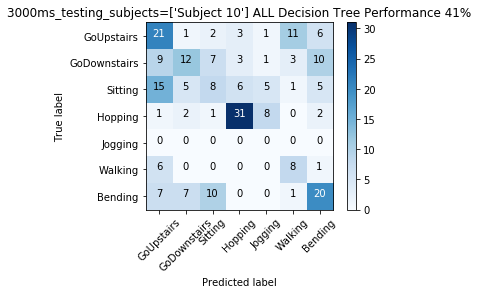

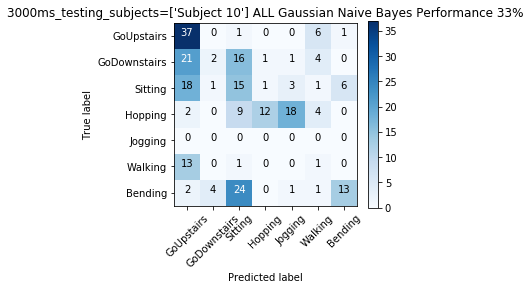

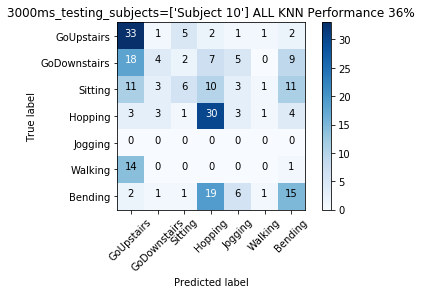

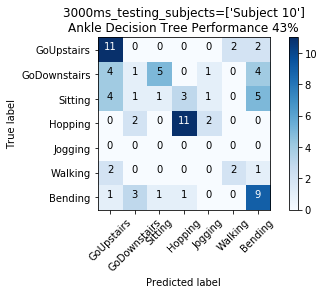

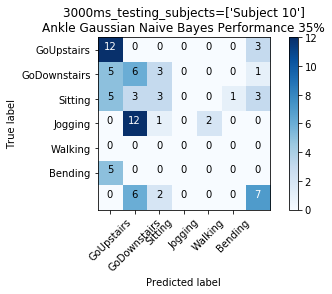

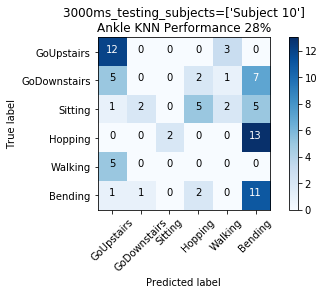

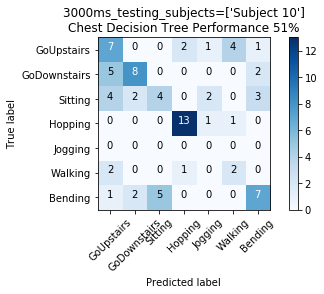

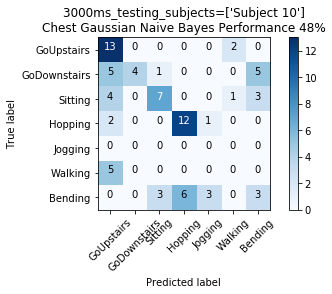

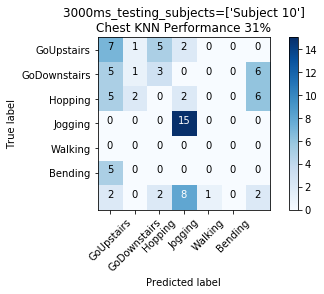

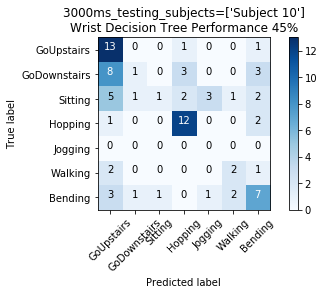

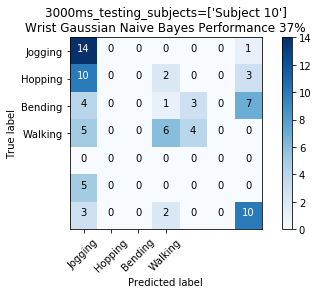

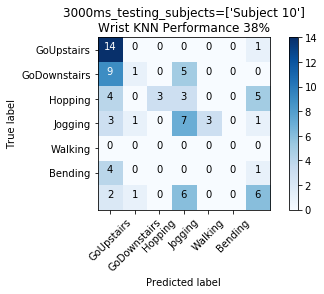

In [88]:
print("\n Test By Age")
test_users = ['Subject 10'];
ignore_users =  ['Subject 10', 'Subject 07'];
train = dataset[~dataset['userID'].isin(ignore_users)]
test = dataset[dataset['userID'].isin(test_users)]
#print(len(dataset))
#print(len(train), set(train['userID']))
#print(len(test), set(test['userID']))
instances_perlabel(test)
test_all_positions(train, test, SLIDING_WINDOW + "ms_testing_subjects=" + str(test_users));

### Test by Age [Suject 07, 10]

In [97]:
print("\n Test By Age")
test_users = ['Subject 07'];
ignore_users =  ['Subject 10', 'Subject 07'];
train = dataset[~dataset['userID'].isin(ignore_users)]
test = dataset[dataset['userID'].isin(test_users)]
#print(len(dataset))
#print(len(train), set(train['userID']))
#print(len(test), set(test['userID']))
instances_perlabel(test)
test_all_positions(train, test, "testing_subjects=" + str(test_users));


 Test By Age
label  GoUpstairs 53
label  GoDownstairs 54
label  Sitting 21
label  Hopping 57
label  Walking 61
label  Bending 55
testing_subjects=['Subject 07'] ALL  Performance Over 10%. scoreDT: 41 scoreGN:32 scoreKN:30
testing_subjects=['Subject 07']
Ankle  Performance Over 10%. scoreDT: 46 scoreGN:34 scoreKN:28
testing_subjects=['Subject 07']
Chest  Performance Over 10%. scoreDT: 42 scoreGN:43 scoreKN:37
testing_subjects=['Subject 07']
Waist , Incomplete Number of Values!
testing_subjects=['Subject 07']
Wrist  Performance Over 10%. scoreDT: 33 scoreGN:30 scoreKN:32


### Test by Age [Suject 07] Training With Subject 10

In [99]:
print("\n Test By Age")
test_users = ['Subject 07'];
ignore_users =  test_users
train = dataset[~dataset['userID'].isin(ignore_users)]
test = dataset[dataset['userID'].isin(test_users)]
#print(len(dataset))
#print(len(train), set(train['userID']))
#print(len(test), set(test['userID']))
instances_perlabel(test)
test_all_positions(train, test, "testing_subjects=" + str(test_users));


 Test By Age
label  GoUpstairs 53
label  GoDownstairs 54
label  Sitting 21
label  Hopping 57
label  Walking 61
label  Bending 55
testing_subjects=['Subject 07'] ALL  Performance Over 10%. scoreDT: 41 scoreGN:31 scoreKN:28
testing_subjects=['Subject 07']
Ankle  Performance Over 10%. scoreDT: 40 scoreGN:37 scoreKN:23
testing_subjects=['Subject 07']
Chest  Performance Over 10%. scoreDT: 45 scoreGN:45 scoreKN:32
testing_subjects=['Subject 07']
Waist , Incomplete Number of Values!
testing_subjects=['Subject 07']
Wrist  Performance Over 10%. scoreDT: 34 scoreGN:33 scoreKN:33


### Test by Age [Suject 10] Training With Subject 07

In [100]:
print("\n Test By Age")
test_users = ['Subject 10'];
ignore_users =  test_users
train = dataset[~dataset['userID'].isin(ignore_users)]
test = dataset[dataset['userID'].isin(test_users)]
#print(len(dataset))
#print(len(train), set(train['userID']))
#print(len(test), set(test['userID']))
instances_perlabel(test)
test_all_positions(train, test, "testing_subjects=" + str(test_users));


 Test By Age
label  GoUpstairs 58
label  GoDownstairs 54
label  Sitting 21
label  Hopping 54
label  Walking 53
label  Bending 59
testing_subjects=['Subject 10'] ALL  Performance Over 10%. scoreDT: 40 scoreGN:33 scoreKN:27
testing_subjects=['Subject 10']
Ankle  Performance Over 10%. scoreDT: 43 scoreGN:33 scoreKN:25
testing_subjects=['Subject 10']
Chest  Performance Over 10%. scoreDT: 36 scoreGN:48 scoreKN:27
testing_subjects=['Subject 10']
Waist , Incomplete Number of Values!
testing_subjects=['Subject 10']
Wrist  Performance Over 10%. scoreDT: 36 scoreGN:39 scoreKN:28


### Training With Ankle And Testing With Others

In [120]:
print("\n Training With Ankle Signals")
test_users = ['Subject 04'];
train = dataset[~dataset['userID'].isin(test_users)]
test = dataset[dataset['userID'].isin(test_users)]
#print(len(dataset))
#print(len(train), set(train['userID']))
#print(len(test), set(test['userID']))
print("\nANKLE -> ANKLE")
classify( train[train['position'].isin(['ankle'])], 
             test[test['position'].isin(['ankle'])], 'Subject04_Ankle-Ankle');
print("\nANKLE -> CHEST")
classify( train[train['position'].isin(['ankle'])], 
             test[test['position'].isin(['chest'])], 'Subject04_Ankle-Chest');
print("\nANKLE -> WAIST")
classify( train[train['position'].isin(['ankle'])], 
             test[test['position'].isin(['waist'])], 'Subject04_Ankle-Waist');
print("\nANKLE -> WRIST")
classify( train[train['position'].isin(['ankle'])], 
             test[test['position'].isin(['wrist'])], 'Subject04_Ankle-Wrist');


 Training With Ankle Signals

ANKLE -> ANKLE
Subject04_Ankle-Ankle  Performance Over 10%. scoreDT: 74 scoreGN:97 scoreKN:61

ANKLE -> CHEST
Subject04_Ankle-Chest  Performance Over 10%. scoreDT: 23 scoreGN:25 scoreKN:35

ANKLE -> WAIST
Subject04_Ankle-Waist  Performance Over 10%. scoreDT: 41 scoreGN:2 scoreKN:25

ANKLE -> WRIST
Subject04_Ankle-Wrist  Performance Over 10%. scoreDT: 41 scoreGN:20 scoreKN:43


### Training With Chest And Testing With Others

In [121]:
print("\n Training With Chest Signals")
test_users = ['Subject 04'];
train = dataset[~dataset['userID'].isin(test_users)]
test = dataset[dataset['userID'].isin(test_users)]
#print(len(dataset))
#print(len(train), set(train['userID']))
#print(len(test), set(test['userID']))
print("\nCHEST -> CHEST")
classify( train[train['position'].isin(['chest'])], 
             test[test['position'].isin(['chest'])], 'Subject04_Ankle-Ankle');
print("\n CHEST -> ANKLE")
classify( train[train['position'].isin(['chest'])], 
             test[test['position'].isin(['ankle'])], 'Subject04_Ankle-Chest');
print("\n CHEST -> WAIST")
classify( train[train['position'].isin(['chest'])], 
             test[test['position'].isin(['waist'])], 'Subject04_Ankle-Waist');
print("\n CHEST -> WRIST")
classify( train[train['position'].isin(['chest'])], 
             test[test['position'].isin(['wrist'])], 'Subject04_Ankle-Wrist');


 Training With Chest Signals

CHEST -> CHEST
Subject04_Ankle-Ankle  Performance Over 10%. scoreDT: 82 scoreGN:84 scoreKN:94

 CHEST -> ANKLE
Subject04_Ankle-Chest  Performance Over 10%. scoreDT: 23 scoreGN:53 scoreKN:48

 CHEST -> WAIST
Subject04_Ankle-Waist  Performance Over 10%. scoreDT: 79 scoreGN:64 scoreKN:61

 CHEST -> WRIST
Subject04_Ankle-Wrist  Performance Over 10%. scoreDT: 28 scoreGN:38 scoreKN:43


### Training With Waist And Testing With Others

In [122]:
print("\n Training With Waist Signals")
test_users = ['Subject 04'];
train = dataset[~dataset['userID'].isin(test_users)]
test = dataset[dataset['userID'].isin(test_users)]
#print(len(dataset))
#print(len(train), set(train['userID']))
#print(len(test), set(test['userID']))
print("\n WAIST -> WAIST")
classify( train[train['position'].isin(['waist'])], 
             test[test['position'].isin(['waist'])], 'Subject04_Waist-Waist');
print("\n WAIST -> ANKLE")
classify( train[train['position'].isin(['waist'])], 
             test[test['position'].isin(['ankle'])], 'Subject04_Waist-Ankle');
print("\n WAIST -> CHEST")
classify( train[train['position'].isin(['waist'])], 
             test[test['position'].isin(['chest'])], 'Subject04_Waist-Chest');
print("\n WAIST -> WRIST")
classify( train[train['position'].isin(['waist'])], 
             test[test['position'].isin(['wrist'])], 'Subject04_Waist-Wrist');


 Training With Waist Signals

 WAIST -> WAIST
Subject04_Waist-Waist  Performance Over 10%. scoreDT: 58 scoreGN:84 scoreKN:79

 WAIST -> ANKLE
Subject04_Waist-Ankle  Performance Over 10%. scoreDT: 41 scoreGN:38 scoreKN:46

 WAIST -> CHEST
Subject04_Waist-Chest  Performance Over 10%. scoreDT: 41 scoreGN:76 scoreKN:74

 WAIST -> WRIST
Subject04_Waist-Wrist  Performance Over 10%. scoreDT: 23 scoreGN:33 scoreKN:28


### Training With Wrist And Testing With Others

In [123]:
print("\n Training With Wrist Signals")
test_users = ['Subject 04'];
train = dataset[~dataset['userID'].isin(test_users)]
test = dataset[dataset['userID'].isin(test_users)]
#print(len(dataset))
#print(len(train), set(train['userID']))
#print(len(test), set(test['userID']))
print("\n WRIST -> WRIST")
classify( train[train['position'].isin(['wrist'])], 
             test[test['position'].isin(['wrist'])], 'Subject04_Wrist-Wrist');
print("\n WRIST -> ANKLE")
classify( train[train['position'].isin(['wrist'])], 
             test[test['position'].isin(['ankle'])], 'Subject04_Wrist-Ankle');
print("\n WRIST -> CHEST")
classify( train[train['position'].isin(['wrist'])], 
             test[test['position'].isin(['chest'])], 'Subject04_Wrist-Chest');
print("\n WRIST -> WAIST")
classify( train[train['position'].isin(['wrist'])], 
             test[test['position'].isin(['waist'])], 'Subject04_Wrist-Waist');


 Training With Wrist Signals

 WRIST -> WRIST
Subject04_Wrist-Wrist  Performance Over 10%. scoreDT: 69 scoreGN:89 scoreKN:66

 WRIST -> ANKLE
Subject04_Wrist-Ankle  Performance Over 10%. scoreDT: 61 scoreGN:87 scoreKN:56

 WRIST -> CHEST
Subject04_Wrist-Chest  Performance Over 10%. scoreDT: 46 scoreGN:30 scoreKN:28

 WRIST -> WAIST
Subject04_Wrist-Waist  Performance Over 10%. scoreDT: 43 scoreGN:53 scoreKN:38


## Semi-Supervised Learning
### Label Propagation

In [139]:
### ref: http://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html#sklearn.semi_supervised.LabelPropagation
### https://en.wikipedia.org/wiki/Label_Propagation_Algorithm
import numpy as np
from sklearn import datasets

def label_propagation(X_Train, Y_Train, X_Test, Y_Test):
    from sklearn.semi_supervised import LabelPropagation
    # Build
    label_prop_model = LabelPropagation(kernel='knn')
    label_prop_model.fit(X_Train, Y_Train)
    # Predict
    Y_Pred = label_prop_model.predict(X_Test);
    # Score
    score = int(label_prop_model.score(X_Test, Y_Test) * 100)
    #print("Label Propagation:", score)
    return {'score': score, 'Y_Pred': Y_Pred};

def label_spreading(X_Train, Y_Train, X_Test, Y_Test):
    from sklearn.semi_supervised import LabelSpreading
    # Build
    label_prop_models_spr = LabelSpreading(kernel='knn')
    label_prop_models_spr.fit(X_Train, Y_Train)
    # Predict
    Y_Pred = label_prop_models_spr.predict(X_Test);
    # Score
    score = int(label_prop_models_spr.score(X_Test, Y_Test) * 100)
    #print("Label Propagation:", score)
    return {'score': score, 'Y_Pred': Y_Pred};
'''
# load dataset
iris = datasets.load_iris()
rng = np.random.RandomState(42)
random_unlabeled_points = rng.rand(len(iris.target)) < 0.3
labels = np.copy(iris.target)
labels[random_unlabeled_points] = -1
el_None = [None for x in labels if x == -1]
el_None += ["Red Flower" for x in labels if x == 0]
el_None += ["Blue Flower" for x in labels if x == 1]
el_None += ["Green Flower" for x in labels if x == 2]
#for label in set(labels):
#    labels[labels.isin([0])]
label_prop_model.fit(iris.data, labels)
# predict
Y_Test = np.copy(iris.target)[random_unlabeled_points]
X_Test = iris.data[random_unlabeled_points]
#
label_propagation(iris.data, labels, X_Test, Y_Test);

# score
score = int(label_prop_model.score(X_Test, Y_Test) * 100)
print("Label Propagation:", score)
'''

'\n# load dataset\niris = datasets.load_iris()\nrng = np.random.RandomState(42)\nrandom_unlabeled_points = rng.rand(len(iris.target)) < 0.3\nlabels = np.copy(iris.target)\nlabels[random_unlabeled_points] = -1\nel_None = [None for x in labels if x == -1]\nel_None += ["Red Flower" for x in labels if x == 0]\nel_None += ["Blue Flower" for x in labels if x == 1]\nel_None += ["Green Flower" for x in labels if x == 2]\n#for label in set(labels):\n#    labels[labels.isin([0])]\nlabel_prop_model.fit(iris.data, labels)\n# predict\nY_Test = np.copy(iris.target)[random_unlabeled_points]\nX_Test = iris.data[random_unlabeled_points]\n#\nlabel_propagation(iris.data, labels, X_Test, Y_Test);\n\n# score\nscore = int(label_prop_model.score(X_Test, Y_Test) * 100)\nprint("Label Propagation:", score)\n'

### Test by Age [Suject 07, 10]

In [167]:
print("\n Test By Age")
print(set(dataset['label']))

def replace_labels(arg):
    arg['label'] = arg['label'].replace(['Walking'], 0);
    arg['label'] = arg['label'].replace(['Hopping'], 1);
    arg['label'] = arg['label'].replace(['GoDownstairs'], 2);
    arg['label'] = arg['label'].replace(['GoUpstairs'], 3);
    arg['label'] = arg['label'].replace(['Jogging'], 4);
    arg['label'] = arg['label'].replace(['Sitting'], 5);
    arg['label'] = arg['label'].replace(['Bending'], 6);
    return arg;

#
test_users = ['Subject 10', 'Subject 07'];
train = dataset[~dataset['userID'].isin(test_users)];
test = dataset[dataset['userID'].isin(test_users)]
# remove labels from subject 10 and 07
print(len(test))
print(set(test['label']))
test['label'] = test['label'].replace(['Walking', 'Hopping', 'GoDownstairs', 
                                         'GoUpstairs', 'Jogging', 'Sitting', 'Bending'], -1);
print(set(test['label']))

# append
print(len(train))
train = train.append(test);
test = dataset[dataset['userID'].isin(test_users)]
test = replace_labels(test);

# label to number
train = replace_labels(train);


# Experiment
#print(set(test['position']))
positions = set(test['position']);
for position in positions:
    print("\nPosition:", position)
    #
    Train = train[train['position'].isin([position])]
    Test = test[test['position'].isin([position])]
    #print("X_Train: ", len(X_Train), " X_Test: ", len(X_Test))
    #
    out = remove_col(Train, Test)
    X_Train = out['X_train']
    Y_Train = out['y_train']
    X_Test = out['X_test']
    Y_Test = out['y_test']
    # validating
    out = label_propagation(X_Train, Y_Train, X_Test, Y_Test);
    score = out['score'];
    Y_Pred = out['Y_Pred'];
    list_of_scores.insert(len(list_of_scores), score);
    print("   L.P.: Position:", position, " score=", score)
    ### Label Spreading
    out = label_spreading(X_Train, Y_Train, X_Test, Y_Test);
    score = out['score'];
    Y_Pred = out['Y_Pred'];
    list_of_scores.insert(len(list_of_scores), score);
    print("   L.S.: Position:", position, " score=", score)


 Test By Age
{'Walking', 'Hopping', 'GoDownstairs', 'GoUpstairs', 'Jogging', 'Sitting', 'Bending'}
480
{'Walking', 'Hopping', 'GoDownstairs', 'GoUpstairs', 'Sitting', 'Bending'}
{-1}
3539

Position: chest
   L.P.: Position: chest  score= 36
   L.S.: Position: chest  score= 40

Position: wrist
   L.P.: Position: wrist  score= 18
   L.S.: Position: wrist  score= 24

Position: ankle
   L.P.: Position: ankle  score= 35
   L.S.: Position: ankle  score= 38


### Training and Testing With Different Positions

In [174]:
FILENAME = "ss_different-positions_"+ SLIDING_WINDOW +"-ms.csv";
csv = pd.DataFrame();

print("\nTraining and Testing With Different Positions")

def replace_labels(arg):
    arg['label'] = arg['label'].replace(['Walking'], 0);
    arg['label'] = arg['label'].replace(['Hopping'], 1);
    arg['label'] = arg['label'].replace(['GoDownstairs'], 2);
    arg['label'] = arg['label'].replace(['GoUpstairs'], 3);
    arg['label'] = arg['label'].replace(['Jogging'], 4);
    arg['label'] = arg['label'].replace(['Sitting'], 5);
    arg['label'] = arg['label'].replace(['Bending'], 6);
    return arg;

# select test user = Subject 04
user = 'Subject 04'
print("\n\nUser:", user)
train = dataset[~dataset['userID'].isin([user])];
test = dataset[dataset['userID'].isin([user])]
# 
test['label'] = test['label'].replace(['Walking', 'Hopping', 'GoDownstairs', 
                                         'GoUpstairs', 'Jogging', 'Sitting', 'Bending'], -1);
train = train.append(test);
test = dataset[dataset['userID'].isin([user])]
test = replace_labels(test);
# label to number
train = replace_labels(train);
# 
positions = set(test['position']);
list_of_scores = list();
for position in positions:
    train_position = position
    for position2 in positions:
        test_position = position2;
        #
        Train = train[train['position'].isin([train_position])]
        Test = test[test['position'].isin([test_position])]
        #
        out = remove_col(Train, Test)
        X_Train = out['X_train']
        Y_Train = out['y_train']
        X_Test = out['X_test']
        Y_Test = out['y_test']
        # validating
        ### Label Propagation
        out = label_propagation(X_Train, Y_Train, X_Test, Y_Test);
        score = out['score'];
        Y_Pred = out['Y_Pred'];
        list_of_scores.insert(len(list_of_scores), score);
        print("   L.P.: Position:", position, " score=", score)
        csv = csv.append(pd.DataFrame({'subject': user,
                             'train_position': train_position,
                              'test_position': test_position,
                              'algorithm':'label_propagation',
                              'window': SLIDING_WINDOW,
                              'score': [score]}));
        ### Label Spreading
        out = label_spreading(X_Train, Y_Train, X_Test, Y_Test);
        score = out['score'];
        Y_Pred = out['Y_Pred'];
        list_of_scores.insert(len(list_of_scores), score);
        print("   L.S.: Position:", position, " score=", score)
        csv = csv.append(pd.DataFrame({'subject': user,
                                      'train_position': train_position,
                                      'test_position': test_position,
                                      'algorithm':'label_spreading',
                                      'window': str(SLIDING_WINDOW),
                                      'score': [score]}));
    print("   Mean:", np.mean(list_of_scores));
csv.to_csv(FILENAME, sep=";");


Training and Testing With Different Positions


User: Subject 04
   L.P.: Position: waist  score= 41
   L.S.: Position: waist  score= 56
   L.P.: Position: waist  score= 61
   L.S.: Position: waist  score= 64
   L.P.: Position: waist  score= 38
   L.S.: Position: waist  score= 52
   L.P.: Position: waist  score= 47
   L.S.: Position: waist  score= 50
   Mean: 51.125
   L.P.: Position: chest  score= 44
   L.S.: Position: chest  score= 50
   L.P.: Position: chest  score= 70
   L.S.: Position: chest  score= 84
   L.P.: Position: chest  score= 23
   L.S.: Position: chest  score= 36
   L.P.: Position: chest  score= 30
   L.S.: Position: chest  score= 33
   Mean: 48.6875
   L.P.: Position: wrist  score= 21
   L.S.: Position: wrist  score= 23
   L.P.: Position: wrist  score= 23
   L.S.: Position: wrist  score= 29
   L.P.: Position: wrist  score= 56
   L.S.: Position: wrist  score= 63
   L.P.: Position: wrist  score= 61
   L.S.: Position: wrist  score= 64
   Mean: 46.625
   L.P.: Position: an

### Test All (Leave-One-Out)

In [164]:
FILENAME = "ss_leave-one-out_"+ SLIDING_WINDOW +"-ms.csv";
csv = pd.DataFrame();

print("\nTest All Leave-One-Out")
#print(set(dataset['label']))

def replace_labels(arg):
    arg['label'] = arg['label'].replace(['Walking'], 0);
    arg['label'] = arg['label'].replace(['Hopping'], 1);
    arg['label'] = arg['label'].replace(['GoDownstairs'], 2);
    arg['label'] = arg['label'].replace(['GoUpstairs'], 3);
    arg['label'] = arg['label'].replace(['Jogging'], 4);
    arg['label'] = arg['label'].replace(['Sitting'], 5);
    arg['label'] = arg['label'].replace(['Bending'], 6);
    return arg;

# Leave-One-Out
users = set(dataset['userID']);
users = sorted(users);
for user in users:
    print("\n\nUser:", user)
    ####
    train = dataset[~dataset['userID'].isin([user])];
    test = dataset[dataset['userID'].isin([user])]
    ### remove labels from subject 10 and 07
    #print(len(test))
    #print(set(test['label']))
    test['label'] = test['label'].replace(['Walking', 'Hopping', 'GoDownstairs', 
                                             'GoUpstairs', 'Jogging', 'Sitting', 'Bending'], -1);
    #print(set(test['label']))
    #### append
    #print(len(train))
    train = train.append(test);
    test = dataset[dataset['userID'].isin([user])]
    test = replace_labels(test);
    # label to number
    train = replace_labels(train);
    positions = set(test['position']);
    list_of_scores = list();
    for position in positions:
        #
        Train = train[train['position'].isin([position])]
        Test = test[test['position'].isin([position])]
        #print("X_Train: ", len(X_Train), " X_Test: ", len(X_Test))
        #
        out = remove_col(Train, Test)
        X_Train = out['X_train']
        Y_Train = out['y_train']
        X_Test = out['X_test']
        Y_Test = out['y_test']
        # validating
        ### Label Propagation
        out = label_propagation(X_Train, Y_Train, X_Test, Y_Test);
        score = out['score'];
        Y_Pred = out['Y_Pred'];
        list_of_scores.insert(len(list_of_scores), score);
        print("   L.P.: Position:", position, " score=", score)
        csv = csv.append(pd.DataFrame({'subject': user,
                              'position': position,
                              'algorithm':'label_propagation',
                              'window': SLIDING_WINDOW,
                              'score': [score]}));
        ### Label Spreading
        out = label_spreading(X_Train, Y_Train, X_Test, Y_Test);
        score = out['score'];
        Y_Pred = out['Y_Pred'];
        list_of_scores.insert(len(list_of_scores), score);
        print("   L.S.: Position:", position, " score=", score)
        csv = csv.append(pd.DataFrame({'subject': user,
                                      'position': position,
                                      'algorithm':'label_spreading',
                                      'window': str(SLIDING_WINDOW),
                                      'score': [score]}));
    print("   Mean:", np.mean(list_of_scores));
csv.to_csv(FILENAME, sep=";");


Test All Leave-One-Out


User: Subject 01
   L.P.: Position: waist  score= 47
   L.S.: Position: waist  score= 59
   L.P.: Position: chest  score= 42
   L.S.: Position: chest  score= 43
   L.P.: Position: wrist  score= 52
   L.S.: Position: wrist  score= 50
   L.P.: Position: ankle  score= 62
   L.S.: Position: ankle  score= 60
   Mean: 51.875


User: Subject 02
   L.P.: Position: waist  score= 47


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\semi_supervised\label_propagation.py:267: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


   L.S.: Position: waist  score= 53
   L.P.: Position: chest  score= 54
   L.S.: Position: chest  score= 68
   L.P.: Position: wrist  score= 48
   L.S.: Position: wrist  score= 48
   L.P.: Position: ankle  score= 78
   L.S.: Position: ankle  score= 79
   Mean: 59.375


User: Subject 03
   L.P.: Position: waist  score= 50
   L.S.: Position: waist  score= 54
   L.P.: Position: chest  score= 41
   L.S.: Position: chest  score= 45
   L.P.: Position: wrist  score= 46
   L.S.: Position: wrist  score= 47
   L.P.: Position: ankle  score= 60
   L.S.: Position: ankle  score= 62
   Mean: 50.625


User: Subject 04
   L.P.: Position: waist  score= 43
   L.S.: Position: waist  score= 62
   L.P.: Position: chest  score= 78
   L.S.: Position: chest  score= 82
   L.P.: Position: wrist  score= 63
   L.S.: Position: wrist  score= 64
   L.P.: Position: ankle  score= 61
   L.S.: Position: ankle  score= 52
   Mean: 63.125


User: Subject 05
   L.P.: Position: waist  score= 74
   L.S.: Position: waist  score


# Experiments

272


C:\Users\barbosa\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\barbosa\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


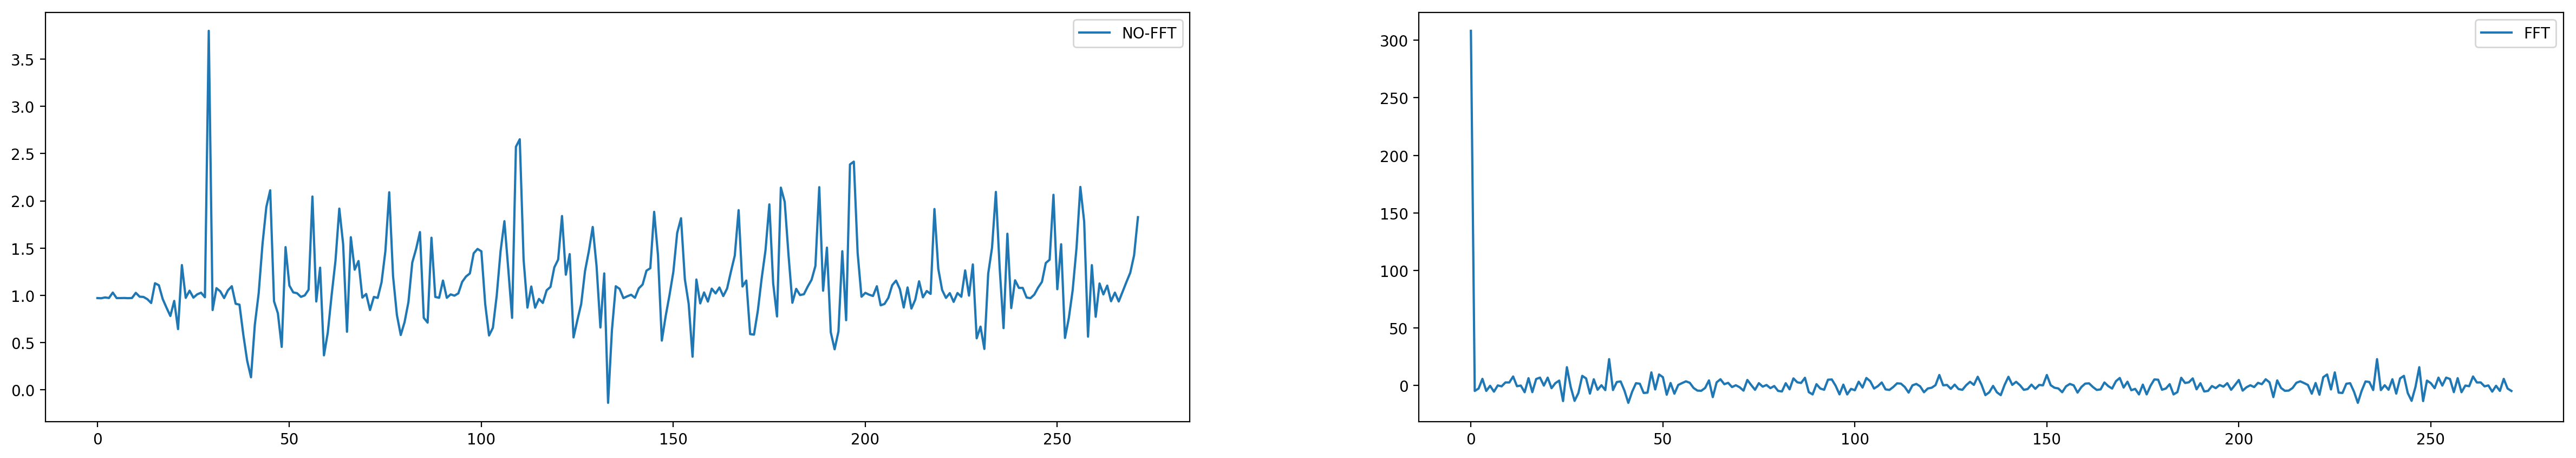

In [139]:
# Without Fast Fourier Transformation
subject = all_values[all_values['userID'].isin(['Subject 01'])]
subject_pos = subject[subject['position'].isin(['ankle'])]
subject_pos_label = subject_pos[subject_pos['experiment'].isin(['Walking_3'])]
subject_pos_label = subject_pos_label.sort_values(['Fts(ms)'])

accX = subject_pos_label['accX'].values
print(len(accX))
# FTT
from scipy.fftpack import fft, ifft
y = fft(accX)

# plot
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

fig, axs=plt.subplots(1,2)
fig.set_size_inches(30, 5, forward=True)
fig.set_dpi(200)
ax=axs.ravel()

ax[0].plot(pd.Series(accX))
ax[0].legend(['NO-FFT'])

ax[1].plot(pd.Series(y))
ax[1].legend(['FFT'])
fig.show()

C:\Users\barbosa\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]
C:\Users\barbosa\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


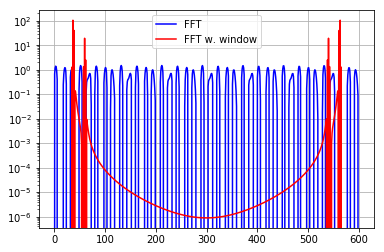

In [24]:
# FTT demo
# Windowing the signal with a dedicated window function helps mitigate spectral leakage. 
# The example below uses a Blackman window from scipy.signal and shows the effect of windowing 
# (the zero component of the FFT has been truncated for illustrative purposes).

from scipy.fftpack import fft
# Number of sample points
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
from scipy.signal import blackman
w = blackman(N)
ywf = fft(y*w)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
import matplotlib.pyplot as plt
plt.semilogy(y, '-b')
plt.semilogy(ywf, '-r')
plt.legend(['FFT', 'FFT w. window'])
plt.grid()
plt.show()